### **Waze User Churn Project**

The following is a project to predict user churn from the Waze app, using data provided by the Google Advanced Data Analytics professional certificate. The dataset represents several variables on user information since onboarding, and some gathered over the period of one month.

This notebook covers the steps of constructing and evaluating a logistic regression model.

In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Package for data modeling
from sklearn.model_selection import train_test_split

# Packages for logistic regression & confusion matrix
from sklearn.metrics import classification_report, precision_score, \
recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
# Import original and cleaned datasets
df0 = pd.read_csv('cleaned_waze_dataset.csv')
df = df0.copy()

# Begin inspecting the data
pd.set_option('display.max_columns', None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   label                            14299 non-null  object 
 1   sessions                         14299 non-null  float64
 2   drives                           14299 non-null  float64
 3   total_sessions                   14299 non-null  float64
 4   n_days_after_onboarding          14299 non-null  int64  
 5   total_navigations_fav1           14299 non-null  float64
 6   total_navigations_fav2           14299 non-null  float64
 7   driven_km_drives                 14299 non-null  float64
 8   duration_minutes_drives          14299 non-null  float64
 9   activity_days                    14299 non-null  int64  
 10  driving_days                     14299 non-null  int64  
 11  device                           14299 non-null  object 
 12  km_per_driving_day

### **Logistic regression model**

To prepare the data for a logistic regression model, we will create binary columns for our two categorical variables, `label` and `device`.

In [3]:
# Create binary `label2` and `device2` columns
df['label2'] = np.where(df['label'] == 'churned', 1, 0)
df['device2'] = np.where(df['device'] == 'iPhone', 1, 0)

df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,label2,device2
0,retained,243.0,200.0,296.748273,2276,208.0,0.0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,13.144225,0.700931,0,0
1,retained,133.0,107.0,326.896596,1225,19.0,64.0,8898.716275,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,168.937685,83.165573,0.253903,0,1
2,retained,114.0,95.0,135.522926,2651,0.0,0.0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,retained,49.0,40.0,67.589221,15,322.0,7.0,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,0,1
4,retained,84.0,68.0,168.247020,1562,166.0,5.0,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


In order to use a logistic regression model, we must determine whether the following assumptions have been met:

* Independent observations (we will assume that observations have been collected independently)

* No extreme outliers (we have addressed extreme outliers in 'Waze_user_churn_1_EDA.ipynb')

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y 

We will now address the third assumption, and the last will be addressed following model creation.

In [4]:
# Generate a correlation matrix with the Pearson standard correlation coefficient
corr_matrix = df.corr(method = 'pearson', numeric_only=True)
corr_matrix

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,label2,device2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.614136,0.443654,0.079293,0.006511,-0.329915,-0.102983,0.034911,0.012704
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.614282,0.444425,0.078282,0.005648,-0.333684,-0.103715,0.035865,0.011684
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,-0.113491,0.254433,0.152906,0.003181,-0.200500,-0.150875,0.024568,0.012138
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,-0.000874,0.003770,-0.302648,0.010629,0.004524,-0.008172,-0.129263,-0.011299
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,0.015180,-0.000224,-0.002548,-0.011891,-0.005384,0.173088,0.052322,-0.001316
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.000603,0.007126,-0.000956,0.008739,0.005109,0.031507,0.015032,-0.000275
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.002092,-0.000904,0.014418,0.095517,0.217392,-0.005812,0.019767,-0.002091
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.007884,-0.012128,0.010030,-0.256899,0.162619,-0.001307,0.040407,-0.007709
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.017840,0.453825,-0.005446,-0.012034,-0.008745,0.008496,-0.303851,-0.010221
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.013550,0.469776,-0.003318,-0.009763,-0.007522,0.007768,-0.294259,-0.003859


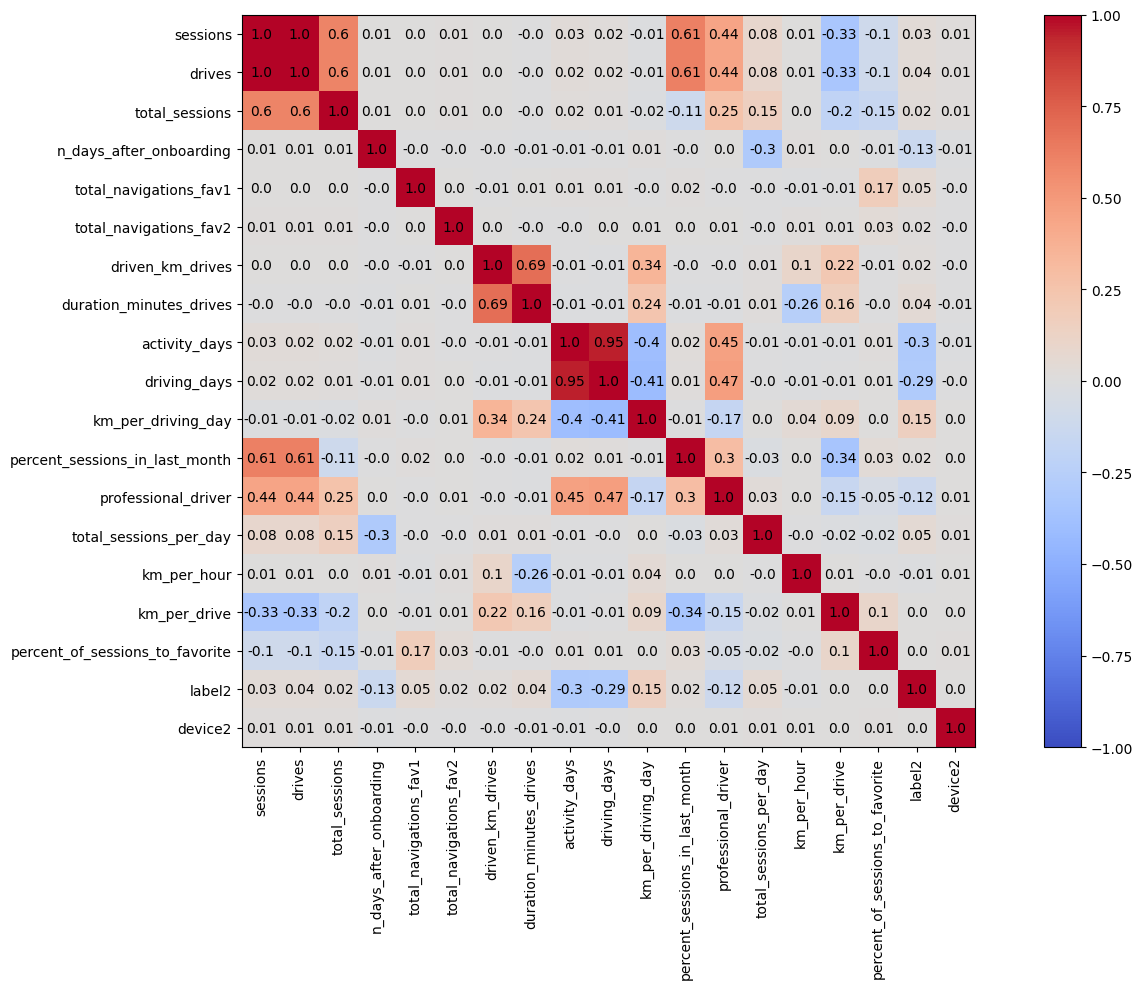

In [5]:
# Plot correlation heatmap
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
plt.imshow(corr_matrix, vmin=-1, vmax = 1, cmap='coolwarm')
plt.colorbar()

# Add ticks and tick labels
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, ha='right')

# Add individual correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(i, j, s=round(corr_matrix.iloc[i, j], 2),
                       ha="center", va="center", color="k")
fig.tight_layout()
plt.show()

Based on our correlation matrix and using a cutoff of the absolute value of 0.7, `sessions` and `drives`, and `activity_days` and `driving_days` are strongly multicollinear. Since `activity_days` and `drives` have slightly higher correlations with `label2` than the other variables, we will retain them for our model.

Next, we will drop the latter, categorical and target features, and a number of engineered features in order to assign the model's variables.

In [6]:
# Isolate predictor variables
X = df.drop(['label', 'label2', 'device', 'sessions', 'driving_days', 
             'km_per_hour', 'km_per_drive', 'percent_of_sessions_to_favorite',
             'percent_sessions_in_last_month', 'total_sessions_per_day'], axis=1)

# Isolate target variable
y = df['label2']

We will then perform a train/test split, instantiate the logistic regression model, and fit our data to the model.

Because the target class is imbalanced (82% retained vs. 18% churned), we will set the `train_test_split` function's stratify parameter to y to ensure the minority dataset appears in training and test sets in the same proportion as overall. Since our predictor variables are unscaled, we will set the `LogisticRegression` function's penalty argument to None.

In [7]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [8]:
# Instantiate the logistic regression model and fit our data
model = LogisticRegression(penalty=None, max_iter=400)
model.fit(X_train, y_train)

# Note - the following error around `max_iter` did not occur when this project was developed in 2023, 
# and could be addressed with scaling a number of predictor variables.

c:\Users\davko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None)

In [9]:
# Create a series with predictor variables and their coefficients
coefficients = pd.Series(data = model.coef_[0], index = X.columns)
coefficients

drives                     0.001939
total_sessions             0.000359
n_days_after_onboarding   -0.000401
total_navigations_fav1     0.001252
total_navigations_fav2     0.000991
driven_km_drives          -0.000013
duration_minutes_drives    0.000110
activity_days             -0.105320
km_per_driving_day         0.000019
professional_driver       -0.007538
device2                    0.022975
dtype: float64

In [10]:
# Get the model intercept
model.intercept_

array([-0.057906])

The above Series shows each variable's coefficient, which is the change in the **log odds** of the target variable for every **one unit** increase in X.

To check the final assumption (linear relationship between X and the logit of y), we will make a regplot. For this demonstration, we will generate only one regplot using `activity_days`, the variable with the largest coefficient.

In [11]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93743048, 0.06256952],
       [0.62187708, 0.37812292],
       [0.76667033, 0.23332967],
       ...,
       [0.91808969, 0.08191031],
       [0.84886849, 0.15113151],
       [0.93335569, 0.06664431]])

In logistic regression, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. This is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

In [12]:
# Create a new DataFrame from the X_train data
logit_data = X_train.copy()

# Create a new 'logit' column
logit_data['logit'] = [np.log(prob[1] / (prob[0])) for prob in training_probabilities]
logit_data.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2,logit
147,108.0,186.192746,3116,243.0,124.0,8898.716275,4668.180092,24,612.305861,1,1,-2.706864
11335,2.0,3.487590,794,114.0,18.0,3286.545691,1780.902733,5,3286.545691,0,1,-0.497523
10416,139.0,347.106403,331,4.0,7.0,7400.838975,2349.305267,15,616.736581,0,0,-1.189605
646,108.0,455.439492,2320,11.0,4.0,6566.424830,4558.459870,18,410.401552,1,1,-2.053940
8002,10.0,89.475821,2478,135.0,0.0,1271.248661,938.711572,27,74.779333,0,1,-3.564191


Text(0.5, 1.0, 'Log-odds: activity days')

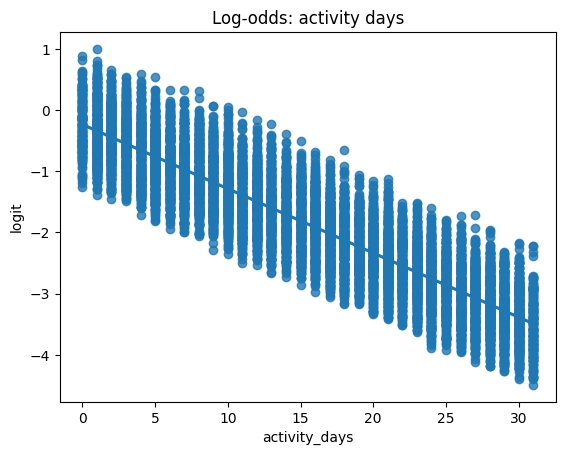

In [13]:
# Regplot of 'activity_days' log-odds 
sns.regplot(x = 'activity_days', y = 'logit', data = logit_data)
plt.title('Log-odds: activity days')

Because the regplot of `activity_days` shows a linear relationship with the log-odds of y, we have met all the assumptions for linear regression and can proceed with interpreting our model.

In [23]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8243356643356643

The model shows a very high accuracy, however because the risks of making a false positive prediction (predicted to churn but did not) with our model are minimal, and that accuracy can be high with an imbalanced dataset and still fail to predict the minority class, we will select the model based on recall score.

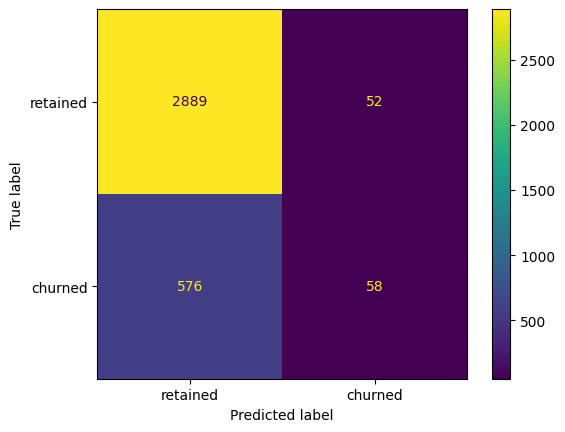

In [24]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=['retained', 'churned'])
disp.plot()

In [25]:
# Calculate precision and recall
precision = precision_score(y_test, y_preds)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_preds)
print(f'Recall: {recall}')

Precision: 0.5272727272727272
Recall: 0.0914826498422713


The model has decent precision yet very low recall, meaning it makes a significant number of false negative predictions and fails to capture users who will actually churn.

In [27]:
# Create a classification report summarizing results
cr = classification_report(y_test, y_preds,  target_names=['retained', 'churned'])
print(cr)

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.53      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



In [31]:
# Create a list of (column_name, coefficient) tuples
# coefs = list(zip([index for index in coefficients.index], [float(coef) for coef in coefficients.values]))
coefs = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
sorted_coefs = sorted(coefs, key = lambda tup: tup[1], reverse=True)
sorted_coefs

[('device2', 0.022975367409900024),
 ('drives', 0.0019394006466991946),
 ('total_navigations_fav1', 0.0012521940538387096),
 ('total_navigations_fav2', 0.0009906210250710307),
 ('total_sessions', 0.00035934654194450064),
 ('duration_minutes_drives', 0.00011000895325173214),
 ('km_per_driving_day', 1.9327133327410537e-05),
 ('driven_km_drives', -1.2927377172276914e-05),
 ('n_days_after_onboarding', -0.00040132700905219556),
 ('professional_driver', -0.007538103953965876),
 ('activity_days', -0.10532010301902821)]

Text(0.5, 1.0, 'Feature importance')

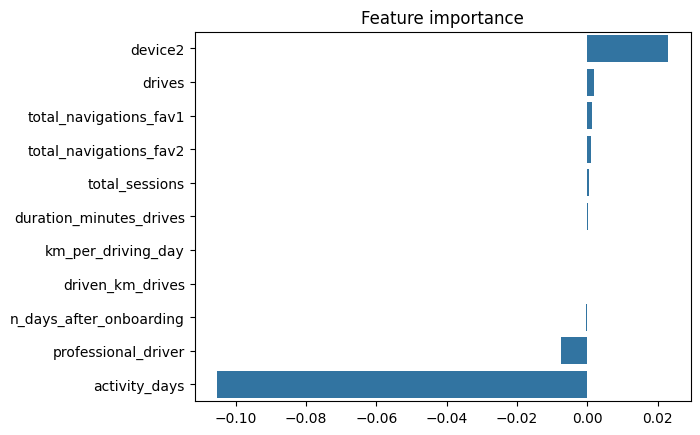

In [32]:
# Plot the feature importances
y, x = zip(*sorted_coefs)
sns.barplot(x = x, y = y, orient='h')
plt.title('Feature importance')

`activity_days` shows the greatest importance in the model, having a negative correlation with user churn. This makes sense, as this variable was strongly correlated with `driving_days`, which we knew to have a negative correlation with churn from EDA. Contrary to what we expected from EDA, `km_per_driving_day` did not exhibit a strong correlation with user churn. The model likely captured interactions between features, resulting in a more predictive yet difficult to explain model.

Due to its poor recall score, we would recommend the model only be used for further exploratory efforts, and not to drive decision making as-is. As next steps, we could scale predictor variables (which would also help with minimizing the model's `max_iter` parameter), or construct a model with different combinations of predictor variables to reduce noise. That `device2` exhibits the second-strongest influence in the model also warrants further exploration and redesign.

This project is continued in 'Waze_user_churn_3_ML_modeling.ipynb'.